

***
***
***

# A2: Written Assessment (Individual) - Classification Modeling Case Study



Machine Learning DAT 5303

Attn: Prof. Chase Kusterer & Ayelet

15 March 2020

***
***
***

## Sources
1. 5 Ways to increase cross-sell success, HBR 2020, https://hbr.org/2016/11/5-ways-to-increase-your-cross-selling

2. 25 Of The Best California Red Wines under $25, https://www.pastemagazine.com/drink/red-wine/25-of-the-best-california-red-wines-under-25/#adelaida-grenache-20-

3. California Top Wines for $15 or less, https://www.foodandwine.com/wine-regions/california/california-top-wines-for-15-dollars-and-less

4. Food and Wine Pairing Basics, https://winefolly.com/wine-pairing/getting-started-with-food-and-wine-pairing/

## Context
As part of <em>Apprentice Chef's</em> product offering, <em>Halfway There</em> (HWT) is another subscription service available to new and existing customers. Existing customers are either inactive, basic or premium subscribers of the Weekly Meal Plan (WP) subscription. 

The aim of this project is to,
1. Produce a model that can accurately predict whether either customer will subscribe to HWT as part of their cross-selling strategy.
2. Produce two insights and one key recommendation for key business stakeholders.

## Stakeholder Address

Refer to the following sections for business and technical information,
1. Section 4 and 5 for key business stakeholders.
2. Section 2 and 3 for key Data Science stakeholders.


In [1]:
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random as rand
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import statsmodels.api as sm

## Ingestion of unscaled data

In [2]:
df_original = pd.read_csv("data/df_feature_engineering.csv")
df_optimization = df_original.copy()
df_optimization = df_optimization.drop("Unnamed: 0", axis=1)

# feature name correction
df_optimization.rename(columns={'MOBILE_NUMBER': 'MOBILE_REGISTRATION'}, inplace=True)

# preparing response variable data
predictor = 'HWT_SUBSCRIBER'
target = df_optimization.loc[:, predictor]
all_features = df_optimization.loc[:, df_optimization.columns.isin([predictor]) == False]

# Feature Significance

## Class Definitions

In [3]:
class ModelResults():
    
    # Class to append results of modeling scenarios into a convenient wrapper
    #    - Assumes pandas as a preloaded resource
    def __init__(self, columns):
        self.columns = columns
        self.df = pd.DataFrame(columns = self.columns)
    
    # save results into class
    def save(self, model_dict_outcome):
        self.df = pd.concat([self.df, pd.DataFrame(model_dict_outcome)])
    
    # display results
    def display(self):
        return self.df
    
    # export results
    def export_csv(self, location):
        self.location = location
        self.df.to_csv(self.location)
    

In [4]:
class NormalityTest():
     
    # Determine whether the supplied function could be sampled from a Gaussian distribution
    #   - Normality tests have been validated by 100 randomly distributed normal floats
    #   - pandas is a pre-assumed dependency
    #      - NormalityTest(np.random.randn(100), 0.05, 0).get_result()
    #   - Source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    
    from scipy import stats
    from numpy.random import seed, randn, seed
 
    def __init__(self, arr, alpha, dataframe, predictor_str):
        self.arr = arr
        self.alpha = alpha
        self.dataframe = dataframe
        self.predictor_str = predictor_str
        return None
    
    def check_normal_dist(self):
        return {
            'is_normally_distributed': {
                'shapiroWilk': self.shapiroWilk(self.alpha),
                'd_agostinoK2': self.d_agostinoK2(self.alpha),
                'anderson_darling': self.anderson_darling(self.alpha)},
        }
        
    def shapiroWilk(self, alpha):
        stat, p = self.stats.shapiro(self.arr)
        if p > alpha:
            return 'Gaussian (fail to reject H0)'
        else:
            return 'Not Gaussian (reject H0)'
    
    def d_agostinoK2(self, alpha):
        stat, p = self.stats.normaltest(self.arr)
        if p > alpha:
            return 'Gaussian (fail to reject H0)'
        else:
            return 'Not Gaussian (reject H0)'
        
    def anderson_darling(self, alpha):
        
        outcome = {
            "statistic": None,
            "percentile": [],
            "sl_cv": [],
            "result": []
        }
        # normality test
        result = self.stats.anderson(self.arr)
        statistic = result.statistic
        p = 0

        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                outcome['sl_cv'].append([sl, cv])
                outcome['result'].append(["Normal (Fail to reject H0)"])
            else:
                outcome['sl_cv'].append([sl, cv])
                outcome['result'].append(["Not Normal (Reject H0)"])
                
        outcome['statistic'] = statistic
        return outcome
    
    def check_population_mean(self, pop_mean):
        
        # NH: population mean is zero
        
        outcome = {}
        data = self.arr
        tset, pval = self.stats.ttest_1samp(data, pop_mean) # t-test
        if pval < 0.05:    # alpha value is 0.05 or 5%
            outcome['status'] = "Reject Null hypothesis"
        else:
            outcome['status'] = "Accept Null hypothesis"
        outcome['sample_mean'] = np.mean(data)
        return outcome
    
    def get_correlation_matrix(self):
        
        # arr and dataframe will be joined to produce correlation matrix
        return self.dataframe.join(pd.DataFrame({'arr': self.arr})).corr()
    
    
    def check_homoscedasticity(self, model):
        
        # generate a qqplot to visually inspect quantiles that break normality
        
        # We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity.
        #    - A p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.
        #    - Source: https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
 
        import pylab 
        import scipy.stats as stats

        measurements = model.resid  
        stats.probplot(measurements, dist="norm", plot=pylab)
        pylab.show()
    
    
    def get_vif(self):
        # Variance inflation factor to measure collinearity among features

        feature_name = []
        vif_value = []
        rsq_value = []
        self.df_vif = self.dataframe.copy()
        if self.predictor_str in self.df_vif.columns:
            self.df_vif = self.df_vif.drop([self.predictor_str], axis=1)
        
        for i in range(0, len(self.df_vif.columns)):
            # prepare features
            X = self.df_vif.loc[:, self.df_vif.columns != self.df_vif.columns[i]]
            y = self.df_vif.loc[:, self.df_vif.columns == self.df_vif.columns[i]]

            # Regress feature on every other feature
            lr = LinearRegression().fit(X, y)

            # Determine rsq
            rsq = lr.score(X, y)
            if rsq != 1:
                vif = round(1 / (1 - rsq), 2)
            else:
                vif = float("inf")

            feature_name.append(self.df_vif.columns[i])
            rsq_value.append(rsq)
            vif_value.append(vif)

        return pd.DataFrame({
                "r_squared": rsq_value,
                "vif": vif_value },
            index = feature_name
        ).sort_values(by="vif")

## Function Definitions

In [5]:
def skl_train_test_pred_results(model, fit_X, fit_y, test_X, test_y, pred_X):
#     quick method to output model, train and test scores
    
    # Fit and score
    mod_fit = model.fit(fit_X, fit_y)
    mod_train_score = model.score(fit_X, fit_y)
    mod_test_score = model.score(test_X, test_y)
    y_pred = mod_fit.predict(pred_X)
    
    return mod_fit, mod_train_score, mod_test_score, y_pred

In [6]:
def skl_mod_confusion_matrix_roc_auc(y_true, y_pred, y_score):
    # Thus in binary classification, 
#         - C00, True  Negatives 
#         - C01, False Positive
#         - C10, False Negative  
#         - C11  True  Positive

    cm = confusion_matrix(y_true, y_pred)
    cm_score = {
        'TN': cm[0, 0],
        'FP': cm[0, 1],
        'FN': cm[1, 0],
        'TP': cm[1, 1]
    }
    
    return cm_score, roc_auc_score(y_true, y_score)

In [7]:
# Variance inflation factor to measure collinearity among features
def vim_multicollinearity(df):
    feature_name = []
    vif_value = []
    rsq_value = []

    for i in range(0, len(df.columns)):
        # prepare features
        X = df.loc[:, df.columns != df.columns[i]]
        y = df.loc[:, df.columns == df.columns[i]]

        # Regress feature on every other feature
        lr = LinearRegression().fit(X, y)
        
        # Determine rsq
        rsq = lr.score(X, y)
        if rsq != 1:
            vif = round(1 / (1 - rsq), 2)
        else:
            vif = float("inf")

        feature_name.append(df.columns[i])
        rsq_value.append(rsq)
        vif_value.append(vif)

    return pd.DataFrame({
            "r_squared": rsq_value,
            "vif": vif_value },
        index = feature_name
    ).sort_values(by="vif")

In [8]:
def statsmodel_ols_lgst(library, model_type, X_train, X_test, y_train, y_test, class_likelihood):
    # Method to automate process of retrieving performance parameters
    
    model_spec = {
        'ols': sm.OLS(y_train, X_train).fit(),
        'lgst': sm.Logit(y_train, X_train).fit(method='ncg')
    }
    
    model_spec_sklearn = {
        'ols': LinearRegression().fit(X_train, y_train),
        'lgst': LogisticRegression().fit(X_train, y_train)
    }
    
    if library == 'statsmodels':
        model = model_spec[model_type]

        # apply class heuristic
        #     - Any class less than 0.5: 0
        #     - ANy class greater than 0.5: 1
        y_pred = model.predict(X_test)
        y_pred = np.array(y_pred)
        y_pred[y_pred < class_likelihood] = 0
        y_pred[y_pred >= class_likelihood] = 1
        y_pred = y_pred.astype(int)
        
        # Get significant features
        mod_sig_features = list(model.pvalues[model.pvalues <= 0.05].index.values)
        
    elif library == 'sklearn':
        model = model_spec_sklearn[model_type]
        
        # apply class heuristic
        y_pred = model.predict(X_test)
        y_pred = np.array(y_pred)
        y_pred[y_pred < class_likelihood] = 0
        y_pred[y_pred >= class_likelihood] = 1
        y_pred = y_pred.astype(int)
        
        # Get significant features
        mod_sig_features = []
        
    else:
        raise Exception("KindError: Library argument is incorrect.")

    # Get scores: output interpreted as probability of predicting class 1
    mod_cm_score, mod_auc_score = skl_mod_confusion_matrix_roc_auc(y_test, y_pred, y_pred)
    mod_precision = mod_cm_score['TP']/(mod_cm_score['TP']+mod_cm_score['FP'])
    
    return model, mod_cm_score, mod_auc_score, mod_precision, mod_sig_features

In [9]:
# outlier and threshold mapping  
def threshold_outlier_flagging(dataframe, feature, threshold_val, threshold_type, bound):
#     automate outlier and flagging process
    if threshold_type == 'outlier':
        if bound == 'high':
            _out_label = "out_{}_hi".format(feature)
            dataframe.loc[:, _out_label] = 0
            for index, val in dataframe.iterrows(): 
                if dataframe.loc[index, feature] > threshold_val:
                    dataframe.loc[index, _out_label] = 1
        elif bound == "low":
            _out_label = "out_{}_lo".format(feature)
            dataframe.loc[:, _out_label] = 0
            for index, val in dataframe.iterrows(): 
                if dataframe.loc[index, feature] < threshold_val:
                    dataframe.loc[index, _out_label] = 1
        else:
            print("Outlier flagging failed")
            
    elif threshold_type == 'threshold':
        if bound == 'high':
            _out_label = "flag_{}_hi".format(feature)
            dataframe.loc[:, _out_label] = 0
            for index, val in dataframe.iterrows(): 
                if dataframe.loc[index, feature] > threshold_val:
                    dataframe.loc[index, _out_label] = 1
        elif bound == "low":
            _out_label = "flag_{}_lo".format(feature)
            dataframe.loc[:, _out_label] = 0
            for index, val in dataframe.iterrows(): 
                if dataframe.loc[index, feature] < threshold_val:
                    dataframe.loc[index, _out_label] = 1
        else:
            print("Threshold flagging failed")
            
    elif threshold_type == 'trend':
        _out_label = "trend_{}".format(feature)
        dataframe.loc[:, _out_label] = 0
        for index, val in dataframe.iterrows(): 
            if dataframe.loc[index, feature] == threshold_val:
                dataframe.loc[index, _out_label] = 1

In [10]:
# plot a ncol x 4 row matrix of distributions
def plot_box_facets(_df, df, fig_rc, viz_type, y, cat_x):
    g_count = 0
    
    if viz_type == 'box':
        if y not in cat_x:
            a = plt.subplot(fig_rc[0], fig_rc[1], g_count+1)

            # plot a facet
            box_plot = sns.boxplot(x=cat_x, y=y, data=df)
            g_count += 1
            
            # despine figure
            sns.despine()
            return box_plot
    else:
        raise Exception("Failed to generated Box Plot")

### Remove Redundant features
    - Known collinear binary features
    - FIRST_NAME, FAMILY_NAME, EMAIL, NAME

In [11]:
df_optimization.drop(
            ["flag_WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT_lo",
            "NAME",
            "EMAIL",
            "FIRST_NAME",
            "FAMILY_NAME"], 
            axis = 1, inplace = True)

### Feature Engineering

#### Weekly Meal Plan subscriber type 

In [12]:
# Ratio of total meals ordered and weeks subscribed to weekly plan are not all perfectly divisible by 3 or 5
#     - Assumption: Weekly plan subscription is a stratified discount plan as opposed to a weekly delivery plan
# If the total number of meals order is greater 
#     - Than a multiple of 3 weeks subscribed to the weekly plan -> Basic subscriber
#     - Than a multiple of 5 5 of weeks subscribed to the weekly -> Premium subscriber
#     - Otherwise inactive weekly

# instantiate features
df_optimization["fe_WP_NOT_SUB"] = 0
df_optimization["fe_WP_INACTIVE_SUB"] = 0 
df_optimization["fe_WP_BASIC_SUB"] = 0 
df_optimization["fe_WP_PREMIUM_SUB"] = 0

# Generate features
for index, val in df_optimization.iterrows(): 
    
    # stratify by type of weekly plan subscriber
    if df_optimization.loc[index, "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT"]*3 > df_optimization.loc[index, "TOTAL_MEALS_ORDERED"]:
        df_optimization.loc[index, "fe_WP_BASIC_SUB"] = 1
    elif df_optimization.loc[index, "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT"]*5 > df_optimization.loc[index, "TOTAL_MEALS_ORDERED"]:
        df_optimization.loc[index, "fe_WP_PREMIUM_SUB"] = 1
    else:
        df_optimization.loc[index, "fe_WP_INACTIVE_SUB"] = 1
    
#     # feature out customers that are not subscribers of a weekly meal plan
    if df_optimization.loc[index, "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT"] == 0:
        df_optimization.loc[index, "fe_WP_NOT_SUB"] = 1

# aggregate by HWT_SUBSCRIBER and share of revenue
df_optimization.loc[:, ["fe_WP_BASIC_SUB", "fe_WP_PREMIUM_SUB", "fe_WP_INACTIVE_SUB", "fe_WP_NOT_SUB", "MOBILE_REGISTRATION", "HWT_SUBSCRIBER", "REVENUE"]].\
groupby(["fe_WP_INACTIVE_SUB", "fe_WP_BASIC_SUB", "fe_WP_PREMIUM_SUB", "fe_WP_NOT_SUB", "MOBILE_REGISTRATION"]).sum()

HWT_SUBSCRIBER  \
fe_WP_INACTIVE_SUB fe_WP_BASIC_SUB fe_WP_PREMIUM_SUB fe_WP_NOT_SUB MOBILE_REGISTRATION                   
0                  0               1                 0             0                                20   
                                                                   1                               132   
                   1               0                 0             0                                32   
                                                                   1                               248   
1                  0               0                 0             0                                45   
                                                                   1                               519   
                                                     1             0                                34   
                                                                   1                               291   

                                                                                            REVENUE  
fe_WP_INACTIVE_SUB fe_WP_BASIC_SUB fe_WP_PREMIUM_SUB fe_WP_NOT_SUB MOBILE_REGISTRATION               
0                  0               1                 0             0                      57376.750  
                                                                   1                     376476.875  
                   1               0                 0             0                      87228.500  
                                                                   1                     604244.125  
1                  0               0                 0             0                     229446.000  
                                                                   1                    1729334.500  
                                                     1             0                     104813.000  
                                                                   1                     911871.750

Dual subscription customers preferred to register for HWT through their mobile phones.
- 519 Inactive WP subscribers were also HWT subscribers and registered with their mobile phones. These customers are not entitled to a weekly plan discount and so there must some other motivating factor.
- 325 customers were unique HWT subscribers and also registered for the service with the mobile phones.

This pool of customers seem hold evidence to suggest that Apprentice's cross-selling strategy is diversifying their revenue streams. And since they have never interfaced Apprentice Chef before, these must be the new customers and the others existing.

In [13]:
# intialize feature
df_optimization.rename(columns={"fe_WP_NOT_SUB": "fe_ONLY_HWT_CUSTOMER"}, inplace=True)

In [14]:
df_optimization\
    .loc[:, df_optimization.columns\
    .isin(["fe_ONLY_HWT_CUSTOMER", "HWT_SUBSCRIBER", "MOBILE_LOGINS_CNT", "PC_LOGINS_CNT", "REVENUE"]) == True]\
    .groupby("fe_ONLY_HWT_CUSTOMER")\
    .agg({"MOBILE_LOGINS_CNT": 'sum', "PC_LOGINS_CNT": 'sum', "HWT_SUBSCRIBER": 'count', "REVENUE": 'sum'})

,MOBILE_LOGINS_CNT,PC_LOGINS_CNT,HWT_SUBSCRIBER,REVENUE
fe_ONLY_HWT_CUSTOMER,,,,
0,2180,8139,1478,3084106.75
1,693,2595,468,1016684.75


From a revenue standpoint, unique HWT customers generated nearly 1/3 of the observed revenue. And even though they prefered to login with their mobile phones, a fair amount of platform engagement occurs on desktop computers.

#### What makes these new customers different?
These new customers receive a half bottle of wine from a local California vineyard every Wednesday.

A typical product that comes from this region, Paso Robles, is Adelaida Grenache (+1$20). It is branded as an affordable yet alluring selection of red wine. 

<img src="https://cdn.pastemagazine.com/www/articles/Best-reds-CA-1-Adelaida.jpg" style="width:20em" >

    "Grenache is a widely planted grape that probably originated in Spain. It likes hot, dry conditions (welcome to Paso
    Robles!) and produces wines with low tannins and a lot of red berry and spice notes-leathery or tarry notes enter the
    picture with age."

The most affordable wine available from that region is a 2006 Camelot Cabernet Sauvignon.

<img src = "https://attardcowines.com/wp-content/uploads/2019/08/78e14edcbf28b3720b6d23db94984107_camelot-rosso-1-5lt.jpg" style="width: 20em" >

Red wines are usually more bitter than white wines the white or sweet whine. From a food pairing perspective, what they make up for in bitterness, sweetness or acidity, they lack in fatiness, spicyness and saltiness. Ideal food compliments for each type of wine are,
1. White - Macaroni for a classy Monday dinner
2. Red - Machego cheese and crackers for an ideal mid week break.

#### Trend, flag and outlier flagging

We have captured two types of customers so far,
1. Existing that are dual subscribers of WP only or WP & HWT.
2. New Customers that only purchased the HWT subscription.

In [15]:
# Seperate customers based on type
df_dual_WP_HWT = df_optimization[df_optimization["fe_ONLY_HWT_CUSTOMER"] == 0]
df_only_HWT = df_optimization[df_optimization["fe_ONLY_HWT_CUSTOMER"] == 1]

# copy dataframes
df_flagged = df_optimization.copy()

# export data for further analysis
df_dual_WP_HWT.to_csv("existing_customers.csv")
df_dual_WP_HWT.to_csv("new_HWT_customers.csv")

Lets identify outliers, trends outliers, high and low regions for each group.

In [16]:
# box plot visualiztion
def f(Feature, Customer):
    
    # get dataframe of choice
    get_df = {
        "Existing": df_dual_WP_HWT,
        "New": df_only_HWT,
        "All": df_optimization,
    }
    
    # Plot feature
    fig = plt.figure(figsize=(15, 15))
    
    ax = plot_box_facets(
        get_df[Customer].loc[:, Feature],
        get_df[Customer],
        viz_type = 'box',
        fig_rc = [4, 4],
        y = Feature,
        cat_x = predictor
    )
    
    print("Copy and paste for auto-flagging: {}".format(Feature))
    
    fig.tight_layout()

# Provide feature selection drop down
widgets.interact(f, Feature=df_dual_WP_HWT.columns[df_dual_WP_HWT.columns != predictor], Customer=["Existing", "New", "All"], )

interactive(children=(Dropdown(description='Feature', options=('REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS…

<function __main__.f(Feature, Customer)>

In [17]:
# autoflagging all customers
threshold_outlier_flagging(df_flagged, "REVENUE", 4200, "outlier", "high")
threshold_outlier_flagging(df_flagged, "TOTAL_MEALS_ORDERED", 175, "outlier", "high")
threshold_outlier_flagging(df_flagged, "UNIQUE_MEALS_PURCH", 12.5, "outlier", "high")
threshold_outlier_flagging(df_flagged, "CUSTOMER_SERVICE_TICKETS_CNT", 12, "outlier", "high")
threshold_outlier_flagging(df_flagged, "MEALS_CANCEL_BEFORE_NOON", 6, "outlier", "high")
threshold_outlier_flagging(df_flagged, "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT", 33, "outlier", "high")
threshold_outlier_flagging(df_flagged, "ORDERS_DELIVERED_BEFORE_DELIVERY_CNT", 7, "outlier", "high")
threshold_outlier_flagging(df_flagged, "ORDERS_DELIVERED_AFTER_DELIVERY_CNT", 8, "outlier", "high")
threshold_outlier_flagging(df_flagged, "FRIDGE_LOCKER_IN_PACKAGE_ROOM", 1, "trend", "hight")
threshold_outlier_flagging(df_flagged, "PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE", 30, "threshold", "high")
threshold_outlier_flagging(df_flagged, "SECONDS_WATCHING_PREP_VID_AVG", 280, "outlier", "high")
threshold_outlier_flagging(df_flagged, "LARGEST_ORDER_SIZE", 8, "outlier", "high")
threshold_outlier_flagging(df_flagged, "MASTER_CLASSES_ATTENDED_CNT", 2, "outlier", "high")
threshold_outlier_flagging(df_flagged, "MEAL_RATING_MEDIAN", 4, "outlier", "high")
threshold_outlier_flagging(df_flagged, "SITE_CLICKS_PER_VISIT_AVG", 8, "outlier", "low")
threshold_outlier_flagging(df_flagged, "PHOTOS_VIEWED_COUNT", 400, "outlier", "high")
threshold_outlier_flagging(df_flagged, "fe_MEAL_CHOICE_SPECIFICITY", 0.28, "outlier", "high")
threshold_outlier_flagging(df_flagged, "fe_SITE_CLICK_RATE", 0.4, "outlier", "high")

## Optimization strategy
- Remove redundant features
    - Test improvement
        - Criteria: count of p-values
- Scale all count, continuous and discrete
    - Test improvement
        - Criteria: count of p-values
- Transform all count, continuous and discrete
    - Test improvement
        - Criteria: count of p-values
- Scale count, discrete and transform continuous
    - Test improvement
        - Criteria: count of p-values
    

#### Define features sets

In [18]:
continuous_features = [
    'REVENUE', 
    'SITE_VISIT_TIME_PER_VISIT_AVG', 
    'PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE', 
    'SECONDS_WATCHING_PREP_VID_AVG'
                    ]

# # MOBILE_LOGINS_CNT dropped, collinearity
count_features = [
    'TOTAL_MEALS_ORDERED', 
    'UNIQUE_MEALS_PURCH', 
    'CUSTOMER_SERVICE_TICKETS_CNT',
    'PRODUCT_CATEGORIES_VIEWED', 
    'MEALS_CANCEL_BEFORE_NOON', 
    'MEALS_CANCEL_AFTER_NOON',
    "PC_LOGINS_CNT", 
    "WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT",
    "ORDERS_DELIVERED_BEFORE_DELIVERY_CNT", 
    "ORDERS_DELIVERED_AFTER_DELIVERY_CNT",
    "MASTER_CLASSES_ATTENDED_CNT", 
    'SITE_CLICKS_PER_VISIT_AVG', 
    'PHOTOS_VIEWED_COUNT'
                    ]


boolean_features = [
    'CROSS_SELL_SUCCESS', 
    'SPECIFIED_TASTE_AND_PREFERENCES',
    'PACKAGE_ROOM_AT_CUSTOMER', 
    'FRIDGE_LOCKER_IN_PACKAGE_ROOM', 
                   ]

discrete_features = [
    'MOBILE_REGISTRATION', 
    'LARGEST_ORDER_SIZE', 
    'MEAL_RATING_MEDIAN'
                    ]

#### Binary transformations of object types

In [19]:
# fields to convert
to_convert = ["fe_CUSTOMER_COMPANY", "fe_CUSTOMER_DOMAIN"]

# make transformations
binary_trans = pd.get_dummies(df_flagged.loc[:, to_convert], drop_first=True)

# drop converted fields
df_flagged.drop(to_convert, axis=1, inplace=True)
df_flagged = df_flagged.join(binary_trans)

#### Setup premodeling parameters

In [20]:
# model comparison statistics
model_type = []
count_sig_features = []
sig_features = []
auc_score = []
sensitivity = []
notes = []

# feature set definition dictionary
sig_feature_sets = {}

# setup ModelResults class
modeling_results = ModelResults(["Model", "Transformation Method", "AUC", "AIC", "R2", "Precision", "Sig. features", "Notes"])

#### Test on statsmodels LinearRegression

In [21]:
target = df_flagged.loc[:, predictor]
all_features = df_flagged.loc[:, df_flagged.columns != predictor]

In [22]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            all_features,
            target,
            test_size = 0.25,
            random_state = 222)

In [23]:
# load model and performance parameters
lr_model, lr_mod_cm_score, lr_mod_auc_score, mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'ols', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": "LinReg",
    "Transformation Method": ["None"],
    "AUC": [lr_mod_auc_score],
    "AIC": [lr_model.aic],
    "R2": [lr_model.rsquared],
    "Precision": [mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge on unscaled/transformed variables"]
})

# define feature set
sig_feature_sets["unscaled_lr"] = sig_features

Optimization terminated successfully.
         Current function value: 0.638760
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Test on statsmodels LogisticRegression

In [24]:
# load model and performance parameters
lgst_model, lgst_mod_cm_score, lgst_mod_auc_score, mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'lgst', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": ["Lgst"],
    "Transformation Method": ["Scale all"],
    "AUC": [lgst_mod_auc_score],
    "AIC": [lgst_model.aic],
    "R2": [lgst_model.prsquared],
    "Precision": [mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge on scaled continuous and count features"]
})

sig_feature_sets["unscaled_lgst"] = sig_features

Optimization terminated successfully.
         Current function value: 0.638760
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid

### Scale all count, continuous and discrete

In [25]:
df_scaled_count_cont_disc = df_flagged.copy()

In [26]:
# # prepare dataframe for scaling
df_to_scale = all_features\
    .loc[:, continuous_features + count_features + discrete_features]

# scale all features
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_to_scale)
df_to_scale = pd.DataFrame(scaler.transform(df_to_scale), columns=df_to_scale.columns)

# merge scaled df with other fields
df_scaled_count_cont_disc.loc[:, df_to_scale.columns] = df_to_scale

#### Test on statsmodels LinearRegression

In [27]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_scaled_count_cont_disc.loc[:, df_scaled_count_cont_disc.columns.isin([predictor]) == False],
            df_scaled_count_cont_disc.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

In [28]:
# load model and performance parameters
lr_model, lr_mod_cm_score, lr_mod_auc_score, mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'ols', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": ["LinReg"],
    "Transformation Method": ["Scale all"],
    "AUC": [lr_mod_auc_score],
    "AIC": [lr_model.aic],
    "R2": [lr_model.rsquared],
    "Precision": [mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge scaled continuous and count features"]
})

sig_feature_sets["scaled_all_lr"] = sig_features

Optimization terminated successfully.
         Current function value: 0.321544
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 46
         Hessian evaluations: 21


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


#### Test on statsmodels Logistic Regression

In [29]:
# load model and performance parameters
lgst_model, lgst_mod_cm_score, lgst_mod_auc_score, mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'lgst', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": ["Logit"],
    "Transformation Method": ["Scale all"],
    "AUC": [lgst_mod_auc_score],
    "AIC": [lgst_model.aic],
    "R2": [lgst_model.prsquared],
    "Precision": [mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge scaled continuous and count features"]
})

sig_feature_sets["scaled_all_lgst"] = sig_features

Optimization terminated successfully.
         Current function value: 0.321544
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 46
         Hessian evaluations: 21


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## Transform continuous and scale count, discrete

In [30]:
df_transformed_cont_scaled_count_disc = df_flagged.copy()

In [31]:
# Tranform continuous by square
for i in df_transformed_cont_scaled_count_disc.loc[:, continuous_features]:
    df_transformed_cont_scaled_count_disc.loc[:, i] = np.log(df_transformed_cont_scaled_count_disc.loc[:, i]).replace({-float('inf'): 0.01})

C:\Users\nrosh\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Expected warning as log calculation is being applied on dummy variables.

In [32]:
# prepare dataframe for scaling
df_to_scale = all_features\
    .loc[:, count_features + discrete_features]

# Scale count and discrete
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_to_scale)
df_to_scale = pd.DataFrame(scaler.transform(df_to_scale), columns=df_to_scale.columns)

# merge scaled df with other fields
df_transformed_cont_scaled_count_disc.loc[:, df_to_scale.columns] = df_to_scale

#### Test on statsmodels LinearRegression

In [33]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_transformed_cont_scaled_count_disc.loc[:, df_transformed_cont_scaled_count_disc.columns.isin([predictor]) == False],
            df_transformed_cont_scaled_count_disc.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

In [34]:
# load model and performance parameters
lr_model_trans_scaled, lr_mod_cm_score, lr_mod_auc_score, lr_mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'ols', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": ["LinReg"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lr_mod_auc_score],
    "AIC": [lr_model_trans_scaled.aic],
    "R2": [lr_model_trans_scaled.rsquared],
    "Precision": [lr_mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge on transformed continuous, scaled count & discrete features"]
})

sig_feature_sets["transformed_scaled_lr"] = sig_features

Optimization terminated successfully.
         Current function value: 0.318692
         Iterations: 33
         Function evaluations: 37
         Gradient evaluations: 69
         Hessian evaluations: 33


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Test on statsmodels Logistic Regression

In [35]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_transformed_cont_scaled_count_disc.loc[:, df_transformed_cont_scaled_count_disc.columns.isin([predictor]) == False],
            df_transformed_cont_scaled_count_disc.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

In [36]:
# load model and performance parameters
lgst_model, lgst_mod_cm_score, lgst_mod_auc_score, mod_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'lgst', X_train, X_test, y_train, y_test, 0.5)

# save model results
modeling_results.save({
    "Model": ["Logit"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lgst_mod_auc_score],
    "AIC": [lgst_model.aic],
    "R2": [lgst_model.prsquared],
    "Precision": [mod_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Failed to converge on scaled continuous and count features"]
})

sig_feature_sets["transformed_scaled_lgst"] = sig_features

Optimization terminated successfully.
         Current function value: 0.318692
         Iterations: 33
         Function evaluations: 37
         Gradient evaluations: 69
         Hessian evaluations: 33


C:\Users\nrosh\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nrosh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\nrosh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid

In [37]:
# Save results
file = "A2 - Optimization Performance Report.csv"
modeling_results.export_csv(file)

# Observe all performance
modeling_results.display()

,Model,Transformation Method,AUC,AIC,R2,Precision,Sig. features,Notes
0,LinReg,None,0.777698,1258.385895,0.433649,0.859375,17,Failed to converge on unscaled/transformed var...
0,Lgst,Scale all,0.500000,2037.900739,-0.019709,0.673511,0,Failed to converge on scaled continuous and co...
0,LinReg,Scale all,0.777698,1258.385895,0.433649,0.859375,18,Failed to converge scaled continuous and count...
0,Logit,Scale all,0.763499,1112.265788,0.486691,0.846626,0,Failed to converge scaled continuous and count...
0,LinReg,"Transform continuous, scale count and discrete",0.781322,1233.197962,0.443342,0.871711,15,"Failed to converge on transformed continuous, ..."
0,Logit,"Transform continuous, scale count and discrete",0.774553,1103.942835,0.491244,0.856698,0,Failed to converge on scaled continuous and co...


In [38]:
vim_multicollinearity(df_transformed_cont_scaled_count_disc.loc[:, sig_features])

,r_squared,vif


In [39]:
# ols summary output for optimal linear regression
lr_model_trans_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HWT_SUBSCRIBER   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     12.71
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          1.62e-121
Time:                        23:35:15   Log-Likelihood:                -529.60
No. Observations:                1459   AIC:                             1233.
Df Residuals:                    1372   BIC:                             1693.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
REVENUE                                         -0.0723      0.041     -1.754      0.080      -0.153       0.009
TOTAL_MEALS_ORDERED                             -0.2163      0.188     -1.152      0.250      -0.585       0.152
UNIQUE_MEALS_PURCH                               0.1908      0.115      1.660      0.097      -0.035       0.416
CUSTOMER_SERVICE_TICKETS_CNT                     0.1752      0.092      1.906      0.057      -0.005       0.356
PRODUCT_CATEGORIES_VIEWED                        0.0172      0.029      0.593      0.553      -0.040       0.074
SITE_VISIT_TIME_PER_VISIT_AVG                    0.0417      0.044      0.945      0.345      -0.045       0.128
MOBILE_REGISTRATION                              0.1165      0.030      3.941      0.000       0.059       0.175
MEALS_CANCEL_BEFORE_NOON                         0.4318      0.091      4.744      0.000       0.253       0.610
MEALS_CANCEL_AFTER_NOON                         -0.1359      0.066     -2.059      0.040      -0.265      -0.006
SPECIFIED_TASTE_AND_PREFERENCES                  0.0759      0.021      3.577      0.000       0.034       0.118
PC_LOGINS_CNT                                    0.0916      0.050      1.834      0.067      -0.006       0.190
MOBILE_LOGINS_CNT                               -0.0388      0.018     -2.102      0.036      -0.075      -0.003
WEEKS_SUBSCRIBED_TO_WEEKLY_PLAN_CNT             -0.0694      0.141     -0.493      0.622      -0.346       0.207
ORDERS_DELIVERED_BEFORE_DELIVERY_CNT             0.0109      0.046      0.236      0.813      -0.080       0.102
ORDERS_DELIVERED_AFTER_DELIVERY_CNT             -0.0504      0.088     -0.571      0.568      -0.224       0.123
PACKAGE_ROOM_AT_CUSTOMER                         0.0114      0.023      0.496      0.620      -0.034       0.057
FRIDGE_LOCKER_IN_PACKAGE_ROOM                    0.0165      0.017      0.945      0.345      -0.018       0.051
PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE            -0.0683      0.012     -5.628      0.000      -0.092      -0.044
SECONDS_WATCHING_PREP_VID_AVG                    0.0554      0.067      0.823      0.411      -0.077       0.187
LARGEST_ORDER_SIZE                              -0.1017      0.131     -0.776      0.438      -0.359       0.155
MASTER_CLASSES_ATTENDED_CNT                      0.0123      0.055      0.226      0.821      -0.095       0.119
MEAL_RATING_MEDIAN                              -0.1063      0.116     -0.920      0.358      -0.333       0.120
SITE_CLICKS_PER_VISIT_AVG                       -0.1614      0.120     -1.342      0.180      -0.397       0.075
PHOTOS_VIEWED_COUNT                              0.1096      0.148      0.742      0.458      -0.180       0.399
missing_FAMILY_NAME             

#### Findings
- The transformed and scaled linear regression produced the best overall performance in auc_score, AIC and rsquared abd were the only models to converge.
- No multicollinearity, <em>Variance Inflation Factor > 9</em>, is observed between features not binary.

Next Steps: Extract significant features from Linear and Logit Regression of and test for convergence.

# Model Optimization

Optimization strategy
- Extract significant features
    - Test on LR and logit
- Selection criteria
    - Overfitting - Cross validation train and test score
    - AUC
    - Precision

In [40]:
# slice dataframe by significant features of last linear regression model
df_transformed_cont_scaled_count_disc.to_csv("df_optimal.csv")
df_significant = df_transformed_cont_scaled_count_disc.copy()
df_significant = df_significant.loc[:, [predictor] + sig_feature_sets['transformed_scaled_lr']]

# df_significant.drop(["fe_CUSTOMER_DOMAIN_professional_domain"], axis=1, inplace=True)

# setup ModelResults class
modeling_optimal_results = ModelResults(["Model", "Transformation Method", "AUC", "AIC", "R2", "Precision", "Sig. features", "Notes"])

## Test on LR for Significance

In [41]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_significant.loc[:, df_significant.columns.isin([predictor]) == False],
            df_significant.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

In [42]:
# load model and performance parameters
lr_model_optimal, lr_optimal_cm_score, lr_optimal_auc_score, lr_mod_optimal_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'ols', X_train, X_test, y_train, y_test, 0.5)

# save results
modeling_optimal_results.save({
    "Model": ["LinReg"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lr_optimal_auc_score],
    "AIC": [lr_model_optimal.aic],
    "R2": [lr_model_optimal.rsquared],
    "Precision": [lr_mod_optimal_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Converged on all transformed and scaled features"]
})


sig_feature_sets['pval_optimal_scale_train_lr'] = sig_features

Optimization terminated successfully.
         Current function value: 0.360265
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 39
         Hessian evaluations: 19


## Test on Logit for Significance

In [43]:
# load model and performance parameters
lgst_model_optimal, lgst_optimal_cm_score, lgst_optimal_auc_score, lgst_mod_optimal_precision, sig_features = statsmodel_ols_lgst('statsmodels', 'lgst', X_train, X_test, y_train, y_test, 0.5)

# save results
modeling_optimal_results.save({
    "Model": ["Logit"],
    "Transformation Method": ["Transform continuous, scale count and discrete"],
    "AUC": [lgst_optimal_auc_score],
    "AIC": [lgst_model_optimal.aic],
    "R2": [lgst_model_optimal.prsquared],
    "Precision": [lgst_mod_optimal_precision],
    "Sig. features": [len(sig_features)],
    "Notes": ["Converged on all transformed and scaled features"]
})

sig_feature_sets['pval_optimal_scale_train_lgst'] = sig_features

Optimization terminated successfully.
         Current function value: 0.360265
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 39
         Hessian evaluations: 19


In [44]:
# Save results
file = "A2 - P-Value Optimization Performance Report.csv"
modeling_optimal_results.export_csv(file)

# Observe all performance
modeling_optimal_results.display()

,Model,Transformation Method,AUC,AIC,R2,Precision,Sig. features,Notes
0,LinReg,"Transform continuous, scale count and discrete",0.761217,1283.260446,0.796912,0.860000,10,Converged on all transformed and scaled features
0,Logit,"Transform continuous, scale count and discrete",0.765119,1081.253055,0.424877,0.848765,8,Converged on all transformed and scaled features


Notes, both models converged on features and must be tested against classical assumptions of a linear model.

## Testing the 7 assumptions of a linear model

1. The error term has a population mean of zero. Thus residuals do not bias predictions.

In [45]:
lr_assumptions = NormalityTest(lr_model_optimal.resid, 0.05, X_train, 'HWT_SUBSCRIBER')
print(lr_assumptions.check_population_mean(0))

{'status': 'Accept Null hypothesis', 'sample_mean': 0.01458782299596335}


2. All independent variables are uncorrelated with error terms (accept for arr). Thus the error term cannot be explained by a predictor.

In [46]:
lr_assumptions.get_correlation_matrix().loc[:, "arr"]

MOBILE_REGISTRATION                            -0.105680
MEALS_CANCEL_BEFORE_NOON                       -0.036222
MEALS_CANCEL_AFTER_NOON                        -0.014871
SPECIFIED_TASTE_AND_PREFERENCES                -0.060946
MOBILE_LOGINS_CNT                              -0.110543
PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE           -0.107511
fe_MEAL_CHOICE_SPECIFICITY                     -0.035961
fe_SUBSCRIPTIONS_SYNERGY                       -0.076382
fe_WP_PREMIUM_SUB                              -0.014070
flag_PRCNT_FOLLOWED_MEAL_RECOM_WEB_MOBILE_hi   -0.032633
out_MASTER_CLASSES_ATTENDED_CNT_hi             -0.002303
fe_CUSTOMER_COMPANY_ge                         -0.004745
fe_CUSTOMER_COMPANY_protonmail                 -0.016012
fe_CUSTOMER_COMPANY_travelers                  -0.004389
fe_CUSTOMER_DOMAIN_professional_domain         -0.028743
arr                                             1.000000
Name: arr, dtype: float64

3. Error terms are uncorrelated with each other. An insignificant positive coeffecient means that the residuals do not have a relationship with each other.

Coeffecient: x1    0.00002
dtype: float64, p-value: 0.0772


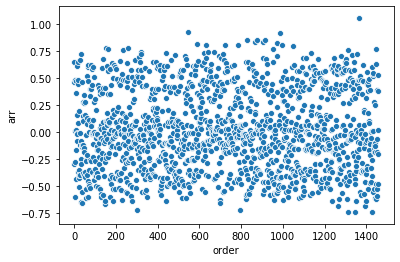

In [47]:
as_4 = sm.OLS(lr_model_optimal.resid, [i for i in range(0, len(lr_model_optimal.resid), 1)]).fit()
print("Coeffecient: {}, p-value: {}".format(as_4.params, round(as_4.pvalues[0], 4)))
sns.scatterplot(
    x = 'order',
    y = 'arr',
    data = pd.DataFrame({"arr": lr_model_optimal.resid, "order": [i for i in range(0, len(lr_model_optimal.resid), 1)]})
)

4. Residual terms obide by normality within the-1.5 and 2 standard deviations. Beyond these intervals, the residual show heteroscadistic behavior.
    - The distribution soft-fails because it regressions are versatile enough to deal with this amount of behavior

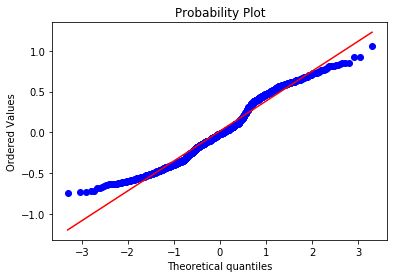

In [48]:
qqplot_homo = lr_assumptions.check_homoscedasticity(lr_model_optimal)

5. No Independent variable is a perfect linear function of other explanatory variables. Thus residuals do not show behaviours of multicollinearity.
    - Variance Inflation Factor(VIF) for each feature

In [49]:
vif = lr_assumptions.get_vif()

# multicollinear features
vif[(vif.vif > 10) & (vif.vif < 50)]

,r_squared,vif


## Final Optimization Effort
1. The model is fit for use for both prediction and statistical feature inference and insights can be drawn from them.
2. A final effort will be made to maximize the predictive power of this model for strategic marketing decisions.
3. sklearn models considered,
    - LinearRegression
    - LogisticRegression
4. AUC probability threshold for AUC & Precision optimization.

In [50]:
# slice dataframe by significant features of last linear regression model
df_significant.to_csv("df_pre_final_model_selection.csv")
df_final_optimization = df_transformed_cont_scaled_count_disc.copy()
df_final_optimization = df_final_optimization.loc[:, [predictor] + sig_feature_sets['pval_optimal_scale_train_lr']]

# df_final_optimization.drop(["fe_CUSTOMER_DOMAIN_professional_domain"], axis=1, inplace=True)

# setup ModelResults class
final_optimal_results = ModelResults(["Model", "Stability", "Test Score", "AUC", "AUC_thresh", "Precision", "Notes"])

In [51]:
# Split training and testing data for cross validation
X_train, X_test, y_train, y_test = train_test_split(
            df_final_optimization.loc[:, df_final_optimization.columns.isin([predictor]) == False],
            df_final_optimization.loc[:, predictor],
            test_size = 0.25,
            random_state = 222)

## Test on sklearn LinearRegression for Significance

In [52]:
# load model and performance parameters
best_precision = 0
best_params = {}
for i in ["ols", "lgst"]:
    for thresh in np.arange(0.1, 1, 0.1):
        lr_final, lr_optimal_cm_score, lr_optimal_auc_score, lr_mod_optimal_precision, sig_features = statsmodel_ols_lgst('sklearn', i, X_train, X_test, y_train, y_test, thresh);
        train_score = lr_final.score(X_train, y_train)
        test_score = lr_final.score(X_test, y_test)
        
        # get model that maximizes precision
        if (lr_mod_optimal_precision > best_precision):
            best_precision = lr_mod_optimal_precision
            best_params = {
                'model':i,
                'cm': lr_optimal_cm_score,
                'train_score': train_score,
                'test': test_score,
                'auc': lr_optimal_auc_score,
                'auc_thresh': thresh,
                'precision': lr_mod_optimal_precision,
            }
            
        # save results
        final_optimal_results.save({
            "Model": [i],
            "Stability": [(train_score-test_score)],
            "Test Score": [test_score],
            "AUC": [lr_optimal_auc_score],
            "AUC_thresh": thresh,
            "Precision": [lr_mod_optimal_precision],
            "Notes": ["Converged successfully"]
        })

        sig_feature_sets['{}_{}'.format(i, thresh)] = X_train.columns;

Optimization terminated successfully.
         Current function value: 0.364978
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 35
         Hessian evaluations: 17
Optimization terminated successfully.
         Current function value: 0.364978
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 35
         Hessian evaluations: 17
Optimization terminated successfully.
         Current function value: 0.364978
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 35
         Hessian evaluations: 17
Optimization terminated successfully.
         Current function value: 0.364978
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 35
         Hessian evaluations: 17
Optimization terminated successfully.
         Current function value: 0.364978
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 35
        

## Model Performance

The best model was a linear model and with a class probability threshold of 0.8. This resulted in an AUC of 0.777 and a fully minimized Precision. This means that the model has a low probability of falsely classifying a customer as a HWT subscriber.

In [53]:
best_params

{'model': 'ols',
 'cm': {'TN': 159, 'FP': 0, 'FN': 141, 'TP': 187},
 'train_score': 0.3917382262670469,
 'test': 0.3749864466001106,
 'auc': 0.7850609756097561,
 'auc_thresh': 0.8,
 'precision': 1.0}

However, the linear model a class probability threshold of 0.6 and a precision of 0.938 achieved an AUC of 0.803

In [54]:
final_optimal_results.display()

,Model,Stability,Test Score,AUC,AUC_thresh,Precision,Notes
0,ols,0.016752,0.374986,0.500000,0.1,0.673511,Converged successfully
0,ols,0.016752,0.374986,0.515723,0.2,0.680498,Converged successfully
0,ols,0.016752,0.374986,0.548790,0.3,0.695745,Converged successfully
0,ols,0.016752,0.374986,0.701076,0.4,0.786842,Converged successfully
0,ols,0.016752,0.374986,0.794092,0.5,0.887755,Converged successfully
0,ols,0.016752,0.374986,0.803440,0.6,0.938776,Converged successfully
0,ols,0.016752,0.374986,0.793440,0.7,0.963134,Converged successfully
0,ols,0.016752,0.374986,0.785061,0.8,1.000000,Converged successfully
0,ols,0.016752,0.374986,0.740854,0.9,1.000000,Converged successfully
0,lgst,0.008623,0.790554,0.774841,0.1,0.862179,Converged successfully


# Key Insights

## Insight 1
The cross-selling strategy has introduced a new customer type; HWT only subscribers. They account for nearly 25% of existing customers.

In [55]:
df_optimization.loc[:, ["fe_WP_BASIC_SUB", "fe_WP_PREMIUM_SUB", "fe_WP_INACTIVE_SUB", "fe_ONLY_HWT_CUSTOMER", "MOBILE_REGISTRATION", "HWT_SUBSCRIBER"]].\
groupby(["fe_WP_INACTIVE_SUB", "fe_WP_BASIC_SUB", "fe_WP_PREMIUM_SUB", "fe_ONLY_HWT_CUSTOMER", "MOBILE_REGISTRATION"]).sum()

HWT_SUBSCRIBER
fe_WP_INACTIVE_SUB fe_WP_BASIC_SUB fe_WP_PREMIUM_SUB fe_ONLY_HWT_CUSTOMER MOBILE_REGISTRATION                
0                  0               1                 0                    0                                20
                                                                          1                               132
                   1               0                 0                    0                                32
                                                                          1                               248
1                  0               0                 0                    0                                45
                                                                          1                               519
                                                     1                    0                                34
                                                                          1                               291

## Insight 2
HWT only subscribers see value in the product as their spend is nearly a third of dual subscription customers

In [56]:
df_optimization\
    .loc[:, df_optimization.columns\
    .isin(["fe_ONLY_HWT_CUSTOMER", "HWT_SUBSCRIBER", "MOBILE_LOGINS_CNT", "PC_LOGINS_CNT", "REVENUE"]) == True]\
    .groupby("fe_ONLY_HWT_CUSTOMER")\
    .agg({"MOBILE_LOGINS_CNT": 'sum', "PC_LOGINS_CNT": 'sum', "HWT_SUBSCRIBER": 'count', "REVENUE": 'sum'})

,MOBILE_LOGINS_CNT,PC_LOGINS_CNT,HWT_SUBSCRIBER,REVENUE
fe_ONLY_HWT_CUSTOMER,,,,
0,2180,8139,1478,3084106.75
1,693,2595,468,1016684.75


# Key Recommendation

To drive cross-selling effectiveness, develop lists of recipes that can be paired with the wines you sell and optimize them for viewing on PC and Mobile.